## Rankability Predicting Sensitivity
### March Madness Dataset

Look for new features:</br>
Existing features:</br>
    Diversity of P metrics</br>
    Graph measures of tournament matrix as Lapacian</br>
    Eigenvalues of tournament matrix</br>

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import copy
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import skew

In [25]:
import sys
# We need to include the path to pyrankability. This could be different for Tim, but altneratively he could point to your copy
sys.path.insert(0,"/disk/home/amy/rankability_toolbox_dev")
import pyrankability

In [26]:
sys.path.insert(0,"/disk/home/amy/sensitivity_study/src")
from sensitivity_tests import *
from utilities import *
from base import *

In [27]:
games={}
years = ["2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018"]
for year in years:
    games[year] = read_data('../data/%steams.txt'%year,'../data/%sgames.txt'%year,'../data/%sMadnessTeams.txt'%year)
games[year]

,team2,team1,notsure1,date,H_A_N1,points1,H_A_N2,points2,team1_name,team2_name,team1_madness,team2_madness
0,1,16,737011,2017-11-13,1,83,-1,69,Arkansas_St,Abilene_Chr,0,0
1,1,41,737114,2018-02-24,-1,74,1,72,Cent_Arkansas,Abilene_Chr,0,0
3,1,143,737018,2017-11-20,-1,75,1,67,Lipscomb,Abilene_Chr,1,0
4,1,143,737045,2017-12-17,1,67,-1,65,Lipscomb,Abilene_Chr,1,0
5,1,199,737056,2017-12-28,1,77,-1,74,New_Orleans,Abilene_Chr,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,351,318,737048,2017-12-20,1,91,-1,74,Utah_St,Youngstown_St,0,0
5536,351,339,737086,2018-01-27,1,85,-1,67,WI_Green_Bay,Youngstown_St,0,0
5537,351,340,737084,2018-01-25,1,66,-1,55,WI_Milwaukee,Youngstown_St,0,0
5538,351,347,737074,2018-01-15,1,77,-1,67,Wright_St,Youngstown_St,1,0


In [28]:
# Note to future self: Parameters from FODS paper but might need to be optimized
direct_thres = 2
spread_thres = 2
weight_indirect = 0.5
Ds = {}
fracs = [0.5, 0.75, 1.] # 25% of total data added per step
#fracs = [0.64, 0.8, 1.] # 25% of current data added per step
pairs = list(zip(fracs[:-1], fracs[1:]))
pair_to_predict = pairs[0]

for year in games.keys():
    print(year)
    Ds[year] = {}
    madness_teams = np.unique(list(games[year].team1_name.loc[games[year].team1_madness == 1]) + list(games[year].team2_name.loc[games[year].team2_madness == 1]))
    game_list = list(games[year].index)
    
    game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                            "team1_score":games[year]['points1'],
                            "team1_H_A_N": games[year]['H_A_N1'],
                            "team2_name":games[year]['team2_name'],
                            "team2_score":games[year]['points2'],
                            "team2_H_A_N": games[year]['H_A_N1'],
                            "date": games[year]['date']
                           }).sort_values(by='date').drop('date',axis=1)
    for frac in fracs:
        upper = int(len(game_df)*frac)
        game_df_sample = game_df.iloc[:upper,:]
        map_func = lambda linked: support_map_vectorized_direct_indirect_weighted(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
        Ds[year][frac] = pyrankability.construct.V_count_vectorized(game_df_sample,map_func).loc[madness_teams,madness_teams]

2002


/disk/home/amy/rankability_toolbox_dev/pyrankability/construct.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = list(game_df.index)


2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [29]:
rankings = {}
taus = {}
results = pd.DataFrame(columns=pairs+["Year"]).set_index("Year")

for year in games.keys():
    rankings[year] = []
    taus[year] = {}
    data = []
    for i in range(len(pairs)):
        pair = pairs[i]
        D1 = Ds[year][pair[0]]
        D2 = Ds[year][pair[1]]
        ranking1 = MasseyRankingAlgorithm().rank(D1.fillna(0).values)
        ranking2 = MasseyRankingAlgorithm().rank(D2.fillna(0).values)
        rankings[year].append((ranking1,ranking2))
        ranking1, ranking2 = rankings[year][i]
        taus[year][pair] = kendall_tau(ranking1,ranking2)
        data.append(taus[year][pair])
    results = results.append(pd.Series(data,index=results.columns,name=year))

In [30]:
taus

{'2002': {(0.5, 0.75): 0.7000000000000001, (0.75, 1.0): 0.7701923076923077},
 '2003': {(0.5, 0.75): 0.6001984126984127, (0.75, 1.0): 0.7857142857142857},
 '2004': {(0.5, 0.75): 0.5182692307692308, (0.75, 1.0): 0.8105769230769231},
 '2005': {(0.5, 0.75): 0.6153846153846155, (0.75, 1.0): 0.8250000000000001},
 '2006': {(0.5, 0.75): 0.4634615384615385, (0.75, 1.0): 0.7682692307692308},
 '2007': {(0.5, 0.75): 0.7028846153846154, (0.75, 1.0): 0.8173076923076924},
 '2008': {(0.5, 0.75): 0.6309523809523809, (0.75, 1.0): 0.7638888888888887},
 '2009': {(0.5, 0.75): 0.5714285714285714, (0.75, 1.0): 0.8303571428571428},
 '2010': {(0.5, 0.75): 0.5567307692307693, (0.75, 1.0): 0.7855769230769231},
 '2011': {(0.5, 0.75): 0.6014047410008778, (0.75, 1.0): 0.8129938542581211},
 '2012': {(0.5, 0.75): 0.6047037539574853, (0.75, 1.0): 0.8263229308005429},
 '2013': {(0.5, 0.75): 0.5223880597014926, (0.75, 1.0): 0.717774762550882},
 '2014': {(0.5, 0.75): 0.5338015803336259, (0.75, 1.0): 0.7919227392449516},


In [31]:
results

,"(0.5, 0.75)","(0.75, 1.0)"
Year,,
2002,0.700000,0.770192
2003,0.600198,0.785714
2004,0.518269,0.810577
2005,0.615385,0.825000
2006,0.463462,0.768269
2007,0.702885,0.817308
2008,0.630952,0.763889
2009,0.571429,0.830357
2010,0.556731,0.785577


In [32]:
df_details = []
def get_rankability_results(n_restarts=250):
    df_ks = []
    df_years = []
    df_fracs = []
    df_p_stats = {}
    for year in games.keys():
        print(year)
        for pair in pairs:
            D = Ds[year][pair[0]].fillna(0)
            #C = pyrankability.construct.C_count(D,0)
            k,details = pyrankability.rank.solve(D,method='lop', num_random_restarts=n_restarts, lazy=False, cont=True)
            p_stats = get_P_stats(details["P"])
            for name, val in p_stats.items():
                if name not in df_p_stats:
                    df_p_stats[name] = []
                df_p_stats[name].append(val)
            df_ks.append(k)
            df_years.append(year)
            df_fracs.append(pair[0])
            df_details.append(details)

    results_temp = {"k":df_ks,"Year":df_years,"Fraction":df_fracs}
    for key, val in df_p_stats.items():
        if key in results_temp:
            raise ValueError("Duplicate column name! Fix collision before moving on!")
        results_temp[key] = val

    return pd.DataFrame(results_temp)

In [33]:
rankability_results = get_rankability_results()
rankability_results

2002
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from file /dev/shm/tmp0xsjz2ht/model.mps
Reading time = 0.09 seconds
lop: 87360 rows, 2080 columns, 262080 nonzeros
Read MPS format model from fi

,k,Year,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau
0,336.495595,2002,0.50,0.862516,140,143.701079,76.278373,0.973077,0.993238
1,642.357143,2002,0.75,0.922537,11,123.782067,55.536875,0.992308,0.997133
2,287.500000,2003,0.50,0.984100,43,67.512962,22.576068,0.991071,0.996640
3,540.899954,2003,0.75,0.947381,61,84.285230,45.697075,0.992063,0.996560
4,313.000000,2004,0.50,0.841212,35,145.265275,81.899160,0.988462,0.996122
5,587.999999,2004,0.75,0.965716,38,77.149206,37.382738,0.988462,0.996314
6,293.500000,2005,0.50,0.906161,42,129.583950,62.107670,0.987500,0.996358
7,588.000000,2005,0.75,0.892190,46,131.384931,65.333016,0.990385,0.996265
8,317.999998,2006,0.50,0.871004,34,125.817328,74.851089,0.989423,0.996498
9,585.000000,2006,0.75,0.829273,93,143.052438,85.056823,0.987500,0.994958


In [34]:
for_corr = rankability_results.loc[rankability_results.Fraction==pair_to_predict[0]].set_index('Year').join(results)
for_corr

,k,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,"(0.5, 0.75)","(0.75, 1.0)"
Year,,,,,,,,,,
2002,336.495595,0.5,0.862516,140,143.701079,76.278373,0.973077,0.993238,0.700000,0.770192
2003,287.500000,0.5,0.984100,43,67.512962,22.576068,0.991071,0.996640,0.600198,0.785714
2004,313.000000,0.5,0.841212,35,145.265275,81.899160,0.988462,0.996122,0.518269,0.810577
2005,293.500000,0.5,0.906161,42,129.583950,62.107670,0.987500,0.996358,0.615385,0.825000
2006,317.999998,0.5,0.871004,34,125.817328,74.851089,0.989423,0.996498,0.463462,0.768269
2007,336.500000,0.5,0.908380,34,130.322676,60.742368,0.984615,0.996233,0.702885,0.817308
2008,295.499993,0.5,0.883606,110,133.108978,67.916470,0.979167,0.994122,0.630952,0.763889
2009,318.500000,0.5,0.968877,46,90.796476,31.448665,0.986111,0.995245,0.571429,0.830357
2010,342.499999,0.5,0.939934,31,98.000000,49.801652,0.985577,0.996228,0.556731,0.785577


In [35]:
for_corr.corr()

,k,Fraction,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,"(0.5, 0.75)","(0.75, 1.0)"
k,1.000000,NaN,-0.449761,0.051646,0.570376,0.521100,-0.028701,0.057571,0.174517,0.107370
Fraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kendall_w,-0.449761,NaN,1.000000,-0.335307,-0.802791,-0.981339,0.276868,0.401257,-0.013013,0.129340
p_lowerbound,0.051646,NaN,-0.335307,1.000000,0.423856,0.341087,-0.496191,-0.520077,0.084167,-0.580620
max_L2_dist,0.570376,NaN,-0.802791,0.423856,1.000000,0.835891,-0.477483,-0.374649,-0.021384,-0.154943
mean_L2_dist,0.521100,NaN,-0.981339,0.341087,0.835891,1.000000,-0.229988,-0.301505,0.025132,-0.149102
min_tau,-0.028701,NaN,0.276868,-0.496191,-0.477483,-0.229988,1.000000,0.887478,-0.076503,0.132354
mean_tau,0.057571,NaN,0.401257,-0.520077,-0.374649,-0.301505,0.887478,1.000000,-0.124403,0.182570
"(0.5, 0.75)",0.174517,NaN,-0.013013,0.084167,-0.021384,0.025132,-0.076503,-0.124403,1.000000,0.348263
"(0.75, 1.0)",0.107370,NaN,0.129340,-0.580620,-0.154943,-0.149102,0.132354,0.182570,0.348263,1.000000


In [36]:
pearsonr(for_corr['k'],for_corr[pair_to_predict])

(0.1745169874221817, 0.5029125121264397)

In [37]:
col_names = [
    'Year',
    '# X* frac',
    'k',
    '# X* frac top 40',
    'kendall_w',
    'p_lowerbound',
    'max_L2_dist',
    'mean_L2_dist',
    'min_tau',
    'mean_tau',
    'Pair'
]

all_score_df = pd.DataFrame(columns=col_names)

c=0
for year in games.keys():
    print(year)
    for pair in pairs:
        V = Ds[year][pair_to_predict[0]]
        rresults = rankability_results.iloc[c,:]
        k = rresults['k']
        details = df_details[c]
        x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
        r = x.sum(axis=0)
        order = np.argsort(r)
        xstar = x.iloc[order,:].iloc[:,order]
        xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
        inxs = np.triu_indices(len(xstar),k=1)
        xstar_upper = xstar.values[inxs[0],inxs[1]]
        nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
        flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
        nfrac_top_40 = flat_frac.iloc[:40].sum()
        entry_data = [
            year,
            nfrac_upper*2,
            k,
            nfrac_top_40,
            rresults["kendall_w"],
            rresults["p_lowerbound"],
            rresults["max_L2_dist"],
            rresults["mean_L2_dist"],
            rresults["min_tau"],
            rresults["mean_tau"],
            pair
        ]
        entry = pd.Series(entry_data,col_names,name=c)
        c+=1
        all_score_df = all_score_df.append(entry)
all_score_df.set_index("Year",inplace=True)

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [38]:
all_score_df = all_score_df.loc[all_score_df.Pair == pair_to_predict].drop('Pair',axis=1).join(results)

In [39]:
all_score_df

,# X* frac,k,# X* frac top 40,kendall_w,p_lowerbound,max_L2_dist,mean_L2_dist,min_tau,mean_tau,"(0.5, 0.75)","(0.75, 1.0)"
Year,,,,,,,,,,,
2002,786,336.495595,407,0.862516,140,143.701079,76.278373,0.973077,0.993238,0.700000,0.770192
2003,1240,287.500000,935,0.984100,43,67.512962,22.576068,0.991071,0.996640,0.600198,0.785714
2004,1080,313.000000,700,0.841212,35,145.265275,81.899160,0.988462,0.996122,0.518269,0.810577
2005,1136,293.500000,697,0.906161,42,129.583950,62.107670,0.987500,0.996358,0.615385,0.825000
2006,1092,317.999998,608,0.871004,34,125.817328,74.851089,0.989423,0.996498,0.463462,0.768269
2007,940,336.500000,604,0.908380,34,130.322676,60.742368,0.984615,0.996233,0.702885,0.817308
2008,1208,295.499993,778,0.883606,110,133.108978,67.916470,0.979167,0.994122,0.630952,0.763889
2009,1392,318.500000,912,0.968877,46,90.796476,31.448665,0.986111,0.995245,0.571429,0.830357
2010,574,342.499999,311,0.939934,31,98.000000,49.801652,0.985577,0.996228,0.556731,0.785577


In [40]:
# TODO: Save all_score_df for easy reuse
# TODO: add function to reload all_score_df from saved file
all_score_df.to_csv("all_score_df.csv")

# all_score_df = pd.read_csv("all_score_df.csv")

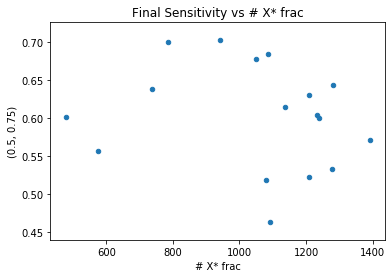

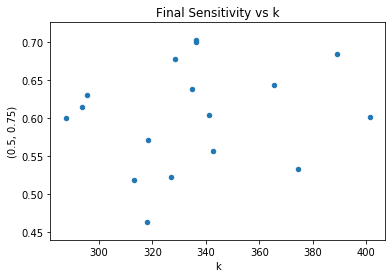

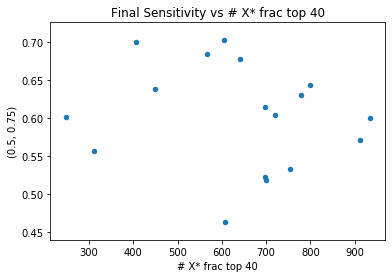

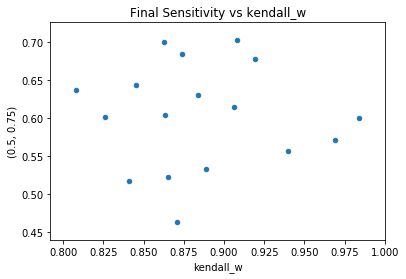

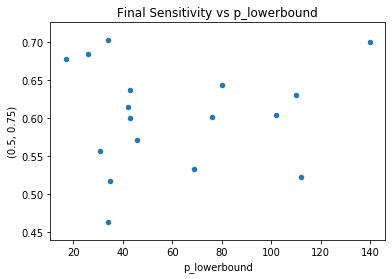

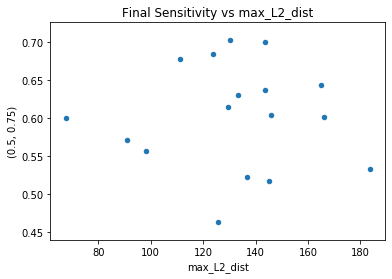

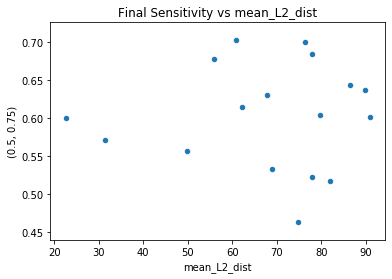

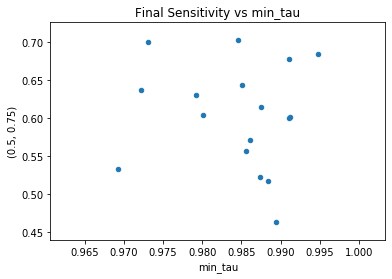

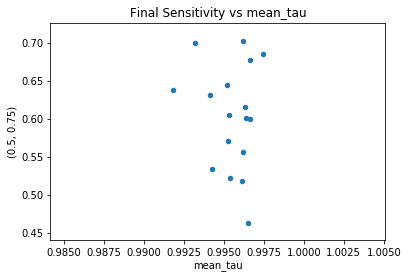

In [41]:
for col in all_score_df.columns:
    if col not in pairs:
        all_score_df.plot.scatter(col, pair_to_predict, title="Final Sensitivity vs " + col)

In [42]:
import sklearn.linear_model as skl_lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

all_feature_cols = [c for c in all_score_df.columns if c not in pairs]

def evaluate(df,pred_col=pair_to_predict,feature_cols=all_feature_cols,model=DummyRegressor(),param_grid={}):
    # fill in evaluat
    loo = LeaveOneOut()
    y = df[pred_col]
    X = df[feature_cols]
    
    grid = GridSearchCV(model,param_grid,refit=True,verbose=2,n_jobs=-1)
    scores = cross_val_score(grid, X, y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=1)
    return pd.Series([len(scores),np.mean(np.abs(scores)),np.std(scores)],index=["Folds","MAE","STD"])

In [43]:
evaluate(all_score_df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric res

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

Folds    17.000000
MAE       0.057941
STD       0.041575
dtype: float64

In [44]:
evaluate(all_score_df,model=SVR(gamma='scale'),param_grid = {'C': [0.1,1,10,100], 'epsilon': [0.1,0.5,1],'kernel': ['linear', 'rbf']})

/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.2s finished
/data/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Folds    17.000000
MAE       0.062650
STD       0.040134
dtype: float64